# Rock Paper Scissor Image Classification

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
tf.random.set_seed(42)

/Users/kullya/josh/DSProjects/Rock-Paper-Scissors/venv-metal/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data, info = tfds.load("rock_paper_scissors", with_info=True, as_supervised=True)
train_data = data["train"]
test_data = data["test"]

2024-04-07 18:25:22.136764: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-04-07 18:25:22.136792: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-07 18:25:22.136796: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-07 18:25:22.136818: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-07 18:25:22.136834: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Let us visualise how does our images loook.! We will also know which image as what label

2024-04-07 18:25:22.318815: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-04-07 18:25:22.336888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


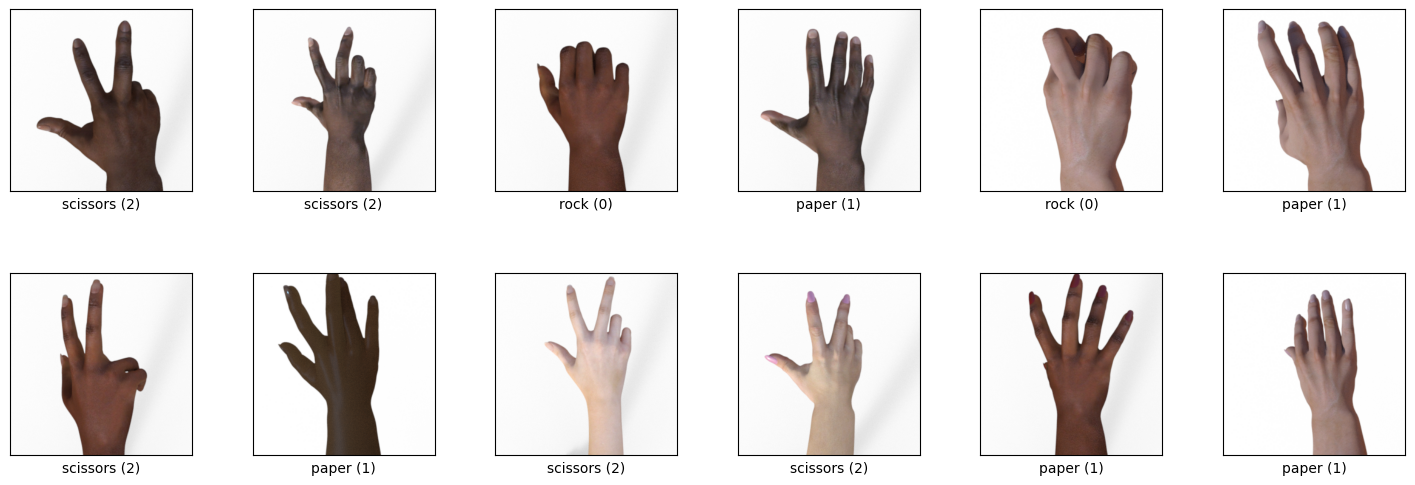

In [3]:
# get some examples
fig = tfds.show_examples(train_data, info, rows=2, cols=6)

This shows us the numeric values for labels.  
0 - Rock  
1 - Paper  
2 - Scissor  

---

Next step is to confirm the size of the dataset and make sure we have sufficient data available. We will take care of the following considerations.  
1. We have suffficient traininy and testing data.
2. What classes do we have.
3. Each class has equivalent amount of data and our dataset is not imbalanced. 
4. Understanding the size of each image.

Size of the dataset

In [4]:
print("Train set size:", info.splits["train"].num_examples)
print("Test set size:", info.splits["test"].num_examples)

Train set size: 2520
Test set size: 372


In [5]:
print("Classes:", info.features["label"].names)

Classes: ['rock', 'paper', 'scissors']


Going with the 3rd consideration, we see how many data points we have per class.

In [6]:
# count occurrences of each class
train_counts = [0, 0, 0]
test_counts = [0, 0, 0]
for image, label in train_data:
    train_counts[label] += 1
for image, label in test_data:
    test_counts[label] += 1

print("Train counts:", train_counts)
print("Test counts:", test_counts)

2024-04-07 18:25:24.236714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train counts: [840, 840, 840]
Test counts: [124, 124, 124]


2024-04-07 18:25:24.441676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


This seems to be an excellent dataset as we have equal data points for each class in the training(840) as well as the testing(124) data. Confirm the shapes of the images.

In [7]:
input_shape = info.features["image"].shape
print("Input shape:", input_shape)

Input shape: (300, 300, 3)


It should always be a good practice to have a validation set while training. This has the following purposes.
1. Prevent overfitting. We will implement multi metric training, early stopping and checkpointing in the future.
2. We cant use the testing data as validation data which would basically mean our model knows the images in the test set and it defeats the purpose of evaluating the performance. Our performance metrics will give all green signals on the basis of just mentioning what it already knows. 
3. Our early stopping and benchmarking will use validation set to identify where other performance has improved or not. So this validation set acts as a pseudo unknown data while training to tell us whether other performance is improving or not.  

So below we have split the data into training and testing. 

## Data Augmentation
Even though we said we have sufficient data, let us add some random variation. For that, we will
1. Flip the image randomly with a 0.5 percent chance right to left and top to bottom. So this way we can randomly get images like
- Horizontally flipped only
- Vertically flipped only
- both horizontally and vertically flipped
2. We will not replace this with the original data as we need both of them. So let us concat this to the original data. We will do this for the validation set as well to measure performance while trinaing. 

In [8]:
train_data = train_data.shuffle(train_data.cardinality(), seed=42).cache()

val_size = 0.1
val_data = train_data.take(int(val_size * info.splits["train"].num_examples))
train_data = train_data.skip(int(val_size * info.splits["train"].num_examples))

# augment the data
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

augmented_train_data = train_data.map(augment)
augmented_val_data = val_data.map(augment)

Now, we cant really map what was the original image and what was it augumented to. Reason being these images are shuffled and we havent cached them. Shuffling is very much necessary so that we dont have all the rocks together and so on. **take(1) picks one random element from the dataset, not the 0th element**. So when we do `take(1)` from respective datasets, they are completely random and not necessarily what is mapped to its augmentation.   

So to demonstrate on visualing these images, let us choose 10 images and augment them and mao them to their augumentation

2024-04-07 18:25:24.775960: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-04-07 18:25:24.792099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


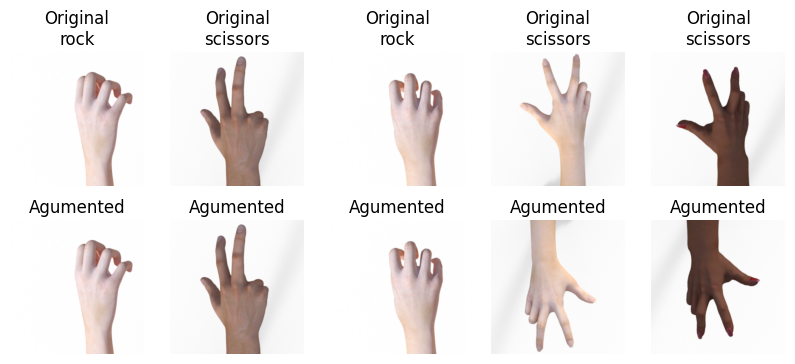

In [9]:
random_images = train_data.take(5)

# in the 1st row, print the original image and in the 2nd row, print the augmented image and set heigh of the image to 5
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, (image, label) in enumerate(random_images):
    axes[0, i].imshow(image)
    axes[0, i].set_title(f"Original\n{info.features['label'].int2str(label)}")
    axes[0, i].axis("off")
    axes[1, i].set_title("Agumented")
    axes[1, i].imshow(augment(image, label)[0])
    axes[1, i].axis("off")

In [10]:
# concatenate the augmented data with the original data
train_data = train_data.concatenate(augmented_train_data)
val_data = val_data.concatenate(augmented_val_data)

In [11]:
# total size of the training and validation data
print("Train size:", train_data.cardinality().numpy())
print("Val size:", val_data.cardinality().numpy())

batch_size = 32

train_data = train_data.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
val_data = val_data.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

test_data = test_data.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

for img, label in train_data.take(1):
    print("Train data shape:", img.shape)
    print("Train label shape:", label.shape)
    
for img, label in val_data.take(1):
    print("Val data shape:", img.shape)
    print("Val label shape:", label.shape)

Train size: 4536
Val size: 504
Train data shape: (32, 300, 300, 3)
Train label shape: (32,)
Val data shape: (32, 300, 300, 3)
Val label shape: (32,)


2024-04-07 18:25:25.202953: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-04-07 18:25:25.203072: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-04-07 18:25:25.203357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence

We originally had 2520 data points. We took 0.9 part of it for training which was 2268. Then we concatenated it with augumented images to double its size making it 4536. Likewise for the validation data. 

Then we batched our data. Using 32 was a trial and error choice. Since I am using M1 metal, which is the GPU for macos, I did not need significantly long time frame per batch and so I could run with a batch size of 32.

We store the `num_classes` in a variable to use it in the last layer.

In [12]:
num_classes = info.features["label"].num_classes

## First model with hardcoded parameters

Even though I have hardcoded the values here, I had derived them from hyper parameter tuning. 

1. Using the input layer which does not compute anything other than properly templating the input shapes. 
2. Used a `Resizing` layer which later on became redundant after I added the `Input` layer. This layer was to ensure that all the images get converted to our actual shapes that we trained on. That is (300, 300).
3. We `Rescale` all the rgb values to decimals from 0-1 to avoid the problem of exploading gradients. Where our values grow larger and larger with time. Larger values will add unwanted biases for and also multiplying larger values takes more time.
4. We had a `RandomFlip` and `RandomRotation` for augumentation but this raised key challenges. 
  - I asked myself, these layers would remain in place inside the network in Production. When we ll have a test image, it will get randomly rotated and flipped. Why would we want that?
  - We cant save models with randomness. The model needs to know what is going to happen. So with additionally need to bundle this as a module and bind the config as to retain the custom variables and functions. 
4. We keep following `Conv2D` with `MaxPool`. This is as per what we read everywhere, to follow a `Conv2D` witha a `MaxPool` but I got very curious about this and thought of why not to have `Conv2D`, another `Conv2D` and then a `MaxPool`. This, logically should help us make more and better filters as the 2nd `Conv2D` has gotten the original values without any loss of information after a `MaxPool`.
5. We flatten the images and add a single `Dense` followed by another `Dense` layer with the exact number of classes we want. That is 3. We use `Softmax` activation function because we want probabilities that sum to 1. This ensures that our predictions are in a range and provide a clear interpretation.
6. For all other layers, we use `ReLU` for computation effieciency, addressing vanishing gradient and to offcourse add non linearity.

**We obviously ended up with an overfitted model as our data is very clean and dont really have significant noise. To tackle that, we used classic `Dropout` and `L2 Regularisation.`**. 
- `Dropout` percentage and `L2 Regularisation` parameters were derived from **Grid Search**.
- We use **Categorical Cross Entropy** for classification because our label belongs to only a single class and we need to penalise longer deviations. But we need to one hot encode our labels which we did not need to really. So we ended using `sparse_categorical_crossentropy` which is same as Categorical Cross Entropy without the need of one hot encoding.

In [13]:
tf.keras.backend.clear_session()

firstModel = tf.keras.Sequential([
  # input
  layers.Input(input_shape),

  # resize and rescale
  layers.Resizing(input_shape[0], input_shape[1]),
  layers.Rescaling(1./255),

  # augmentations
  # layers.RandomFlip("horizontal_and_vertical", seed = 42),
  # layers.RandomRotation(0.2),

  # convolutions
  layers.Conv2D(32, 3, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  layers.Dense(num_classes, activation="softmax")
])

firstModel.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

firstModel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 147, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 341056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    21,827,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,847,235 (83.34 MB)

 Trainable params: 21,847,235 (83.34 MB)

 Non-trainable params: 0 (0.00 B)

We fit the model below but end up with crucial observations while development.

In [14]:
history = firstModel.fit(train_data, validation_data=val_data, epochs=20, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)], verbose = 1)

Epoch 1/20


2024-04-07 18:25:26.003092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


142/142 ━━━━━━━━━━━━━━━━━━━━ 84s 581ms/step - accuracy: 0.5959 - loss: 4.4141 - val_accuracy: 0.9425 - val_loss: 1.0270
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 84s 589ms/step - accuracy: 0.9473 - loss: 0.8337 - val_accuracy: 0.9603 - val_loss: 0.6851
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 84s 589ms/step - accuracy: 0.9672 - loss: 0.6093 - val_accuracy: 0.9722 - val_loss: 0.6152
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 80s 560ms/step - accuracy: 0.9713 - loss: 0.5424 - val_accuracy: 0.9782 - val_loss: 0.5525
Epoch 5/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 73s 517ms/step - accuracy: 0.9808 - loss: 0.4934 - val_accuracy: 0.9782 - val_loss: 0.5554
Epoch 6/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 77s 543ms/step - accuracy: 0.9767 - loss: 0.4916 - val_accuracy: 0.9841 - val_loss: 0.4849
Epoch 7/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 86s 607ms/step - accuracy: 0.9877 - loss: 0.4291 - val_accuracy: 0.9802 - val_loss: 0.4579
Epoch 8/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 79s 557ms/step - accuracy: 0.9857 - loss: 0.4003 - val

At times, the early stopping triggers but we still had a vveerryy low performance. But we know that the model has randomisation due to the Dropout layer. (Opps, did I mention before that we cant save a model with randomisation but Dropout is actually random? Right! But Dropout layer goes inactive during evaluation and prediction so the network by itself has unknowngily handled that randomisation). With that in mind, I knew that the model can actually perform differently if I rerun it again. 

So without recompiling, I just ran `fit` but learnt an excellent lesson! The model resumes with its existing weights, i.e. from the point where the early stopping was triggered. So this Early Stopping can practically raise false alarms!! I have handled this later. 

In [15]:
firstModel.evaluate(test_data)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.5663 - loss: 1.4040


[1.3334535360336304, 0.5752688050270081]

This is not favorable. 50% accuracy is same as just flipping a coin and mapping it to something. We need to do better. 


But, let us plot the performance over time and understand if our model was actually improving over time. We can do it by manually inspecting the logs above but images are easier to interpret!

### Plot the history

In [16]:
def plotHistory(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(10, 3))
  plt.subplot(1, 2, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

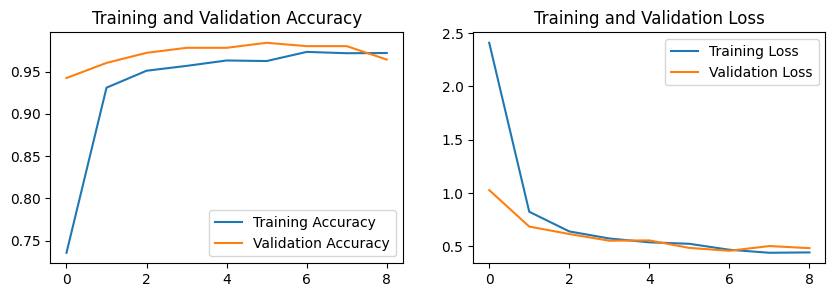

In [17]:
plotHistory(history)

Performance did improve actually so let us just backup this model.

In [18]:
# save the firstModel
tf.saved_model.save(firstModel, "models/firstModel")

INFO:tensorflow:Assets written to: models/firstModel/assets


INFO:tensorflow:Assets written to: models/firstModel/assets


> Early Stopping can raise false alarms.

An option is to use multiple parameters to evaluate model performance instead of just the accuracy. So let us use accuracy and F1 score. We use F1 because we have to reduce False Positives and False Negatives with equal importance. Else, we could have focused on F0.5 or F2 score.  

Since TF doesnt have an inbuilt way to monitor multiple parameters, let us build a custom EarlyStopping class. For this, we will need to one hot encode our labels. But, cant we just use Sparse Categorical Cross Entropy. Not here really because we have softmax in the last layer which outputs probabilities per class. To calculate `F1 Score`, we will recieve this class probabilites as predictions and we will have single integer labels as our true labels. To tackle this, we will encode the data and have a consistent format.

In [19]:
from tensorflow.keras import backend as K
import numpy as np

encoded_train_data = train_data.map(lambda imgs, labels: (imgs, tf.one_hot(labels, num_classes)))
encoded_val_data = val_data.map(lambda imgs, labels: (imgs, tf.one_hot(labels, num_classes)))
encoded_test_data = test_data.map(lambda imgs, labels: (imgs, tf.one_hot(labels, num_classes)))

In [20]:
for img, label in encoded_train_data.take(1):
    print("Train data shape:", img.shape)
    print("Train label shape:", label.shape)

Train data shape: (32, 300, 300, 3)
Train label shape: (32, 3)


2024-04-07 18:37:42.618635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


We see that the labels have changed the shape from `(32,)` to `(32, 3)` with 32 being the batch size. New shape has the one hot encoded labels and so the shape of 3 for each label.

We also write custom function for `F1 Score` and add a `MultiMetricEarlyStopping` which is extended from `tf.keras.callbacks.Callback`. To tackle the false alarms, we make sure that both `F1 Score` and the `Accuracy` has dropped to trigger early stopping.

Very carefully see how we have decorated the `f1` function with `@keras.saving.register_keras_serializable(package="my_package", name="f1")`. This is needed for saving the model and loading it again. use the same decorator and function while loading the model as well.

In [21]:
import keras

@keras.saving.register_keras_serializable(package="my_package", name="f1")
def f1(y_true, y_pred):
    # Calculate precision and recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    # Calculate precision and recall
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    # Calculate F1-score
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    return f1

class MultiMetricEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, metrics_to_monitor, patience=0):
        super().__init__()
        self.metrics_to_monitor = metrics_to_monitor
        self.patience = patience
        self.best_values = {metric: -1 for metric in metrics_to_monitor}
        self.wait = 0

    
    def on_epoch_end(self, epoch, logs=None):
        # Check improvement on all monitored metrics
        mets = [(logs.get(metric), self.best_values[metric]) for metric in self.metrics_to_monitor]
        reduced = [logs.get(metric) < self.best_values[metric] for metric in self.metrics_to_monitor]
        
        if not all(reduced):
            self.best_values = {metric: logs.get(metric) for metric in self.metrics_to_monitor}
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.stop_training = True

In [22]:
# clone model
secondModel = tf.keras.Sequential([
  # input
  layers.Input(input_shape),

  # resize and rescale
  layers.Resizing(input_shape[0], input_shape[1]),
  layers.Rescaling(1./255),

  # convolutions
  layers.Conv2D(32, 3, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  layers.MaxPooling2D(),
  layers.Dropout(0.3, seed=42),
  layers.Flatten(),
  layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  layers.Dense(num_classes, activation="softmax")
])

secondModel.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", f1])
multiMetricEarlyStopping = MultiMetricEarlyStopping(metrics_to_monitor=['val_accuracy', 'val_f1'], patience=2)

Our model architecture has remained the same but notice we added `f1` in the `metrics` while compiling the model. With this, we will directly have loss, accuracy and the f1 score inside `on_epoch_end`. This gives more modularity. Else, code looks bad if we measure this metric in the extended Callback class.

In [23]:
secondHistory = secondModel.fit(encoded_train_data, validation_data=encoded_val_data, epochs=20, callbacks=[multiMetricEarlyStopping], verbose = 1)

Epoch 1/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 82s 563ms/step - accuracy: 0.6423 - f1: 0.5628 - loss: 4.0962 - val_accuracy: 0.9187 - val_f1: 0.9114 - val_loss: 0.9999
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 78s 547ms/step - accuracy: 0.9376 - f1: 0.9352 - loss: 0.8258 - val_accuracy: 0.9464 - val_f1: 0.9492 - val_loss: 0.7424
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 80s 562ms/step - accuracy: 0.9622 - f1: 0.9614 - loss: 0.6133 - val_accuracy: 0.9702 - val_f1: 0.9732 - val_loss: 0.6102
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 75s 530ms/step - accuracy: 0.9714 - f1: 0.9727 - loss: 0.5323 - val_accuracy: 0.9881 - val_f1: 0.9892 - val_loss: 0.5365
Epoch 5/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 81s 570ms/step - accuracy: 0.9750 - f1: 0.9758 - loss: 0.4881 - val_accuracy: 0.9762 - val_f1: 0.9758 - val_loss: 0.5315
Epoch 6/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 79s 557ms/step - accuracy: 0.9768 - f1: 0.9758 - loss: 0.4700 - val_accuracy: 0.9802 - val_f1: 0.9824 - val_loss: 0.5189


Notice how we also have the f1 score logged with each epoch. 

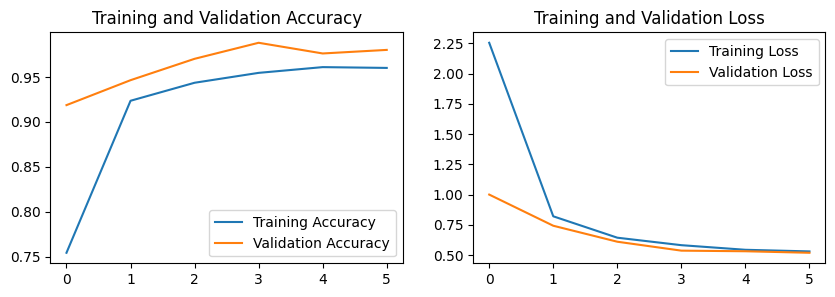

In [24]:
plotHistory(secondHistory)

Accuracy plot is not smooth but it doesnt necessarily be smooth

In [25]:
secondModel.evaluate(encoded_test_data)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.6573 - f1: 0.6492 - loss: 1.2824


[1.2895622253417969, 0.6532257795333862, 0.651082456111908]

In [26]:
# get the labels from model3
mod2Preds = secondModel.predict(encoded_test_data)
mod2PredLabels = np.argmax(mod2Preds, axis=1)

true_labels = []
for img, label in test_data:
    true_labels.extend(label.numpy())

true_labels = np.array(true_labels)

# build the confusion matrix
conf_matrix = tf.math.confusion_matrix(true_labels, mod2PredLabels)
print(conf_matrix)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step
tf.Tensor(
[[102   0  22]
 [  4  61  59]
 [ 13  31  80]], shape=(3, 3), dtype=int32)


2024-04-07 18:45:42.079428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


This has an alarming number of false positives and false negatives.

In [27]:
# save the second model
tf.saved_model.save(secondModel, "models/secondModel")

INFO:tensorflow:Assets written to: models/secondModel/assets


INFO:tensorflow:Assets written to: models/secondModel/assets


**But early stopping saves the final weights which are not really the best. Let us use checkpointing which only updates on better and better performance.**

Does that make Early Stopping redundant? Ofcourse. But I am blessed with genuninely good computation power and time availability.

But we also saw that the model is still overfitting. Knowing that the validation performance is much higher but test performance is significantly low.

In [111]:
from tensorflow.keras.callbacks import ModelCheckpoint
# clone model
model3 = tf.keras.Sequential([
  # input
  layers.Input(input_shape),

  # resize and rescale
  # layers.Resizing(input_shape[0], input_shape[1]),
  layers.Rescaling(1./255),

  # convolutions
  layers.Conv2D(32, 3, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  layers.MaxPooling2D(),
  layers.Dropout(0.25, seed=42),
  layers.Flatten(),
  layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  layers.Dropout(0.3, seed=42),
  layers.Dense(num_classes, activation="softmax")
])

model3.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", f1])

checkpoint_callback = ModelCheckpoint(filepath='models/best_model_checkpoint.keras',
                                      save_best_only=True,  # Only save the best model
                                      save_weights_only=False,  # Save the entire model
                                      monitor='val_f1',  # Monitor validation F1 score
                                      mode='max',  # Save the model when validation F1 score improves
                                      verbose=1)  # Print verbose messages

history3 = model3.fit(encoded_train_data, validation_data=encoded_val_data, epochs=3, callbacks=[checkpoint_callback], verbose = 1)

Epoch 1/3
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.5162 - f1: 0.3451 - loss: 4.8313
Epoch 1: val_f1 improved from -inf to 0.93814, saving model to models/best_model_checkpoint.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 80s 544ms/step - accuracy: 0.5172 - f1: 0.3465 - loss: 4.8156 - val_accuracy: 0.9464 - val_f1: 0.9381 - val_loss: 1.1170
Epoch 2/3
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.9332 - f1: 0.9214 - loss: 0.9235
Epoch 2: val_f1 did not improve from 0.93814
142/142 ━━━━━━━━━━━━━━━━━━━━ 80s 564ms/step - accuracy: 0.9331 - f1: 0.9213 - loss: 0.9237 - val_accuracy: 0.9325 - val_f1: 0.9370 - val_loss: 0.9248
Epoch 3/3
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.9511 - f1: 0.9481 - loss: 0.7919
Epoch 3: val_f1 improved from 0.93814 to 0.94928, saving model to models/best_model_checkpoint.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 85s 596ms/step - accuracy: 0.9510 - f1: 0.9479 - loss: 0.7924 - val_accuracy: 0.9524 - val_f1: 0.9493 - val_loss: 0.8767


This very well mentions when the model had better performance and does not backup the model with lower perfomance. So we dont bother with newer epochs performing worse. But, our final weights are not necessarily the best weights so we will load back the model and evaluate on that.

In [112]:
bestModel = tf.keras.models.load_model('models/best_model_checkpoint.keras')
bestModel.evaluate(encoded_test_data)

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 0.7068 - f1: 0.7063 - loss: 1.5253


[1.5557880401611328, 0.6881720423698425, 0.6832354664802551]

Woah!! this is great! We will also confirm the confusion matrix.

In [113]:
# get the labels from model3
pred_labels = bestModel.predict(encoded_test_data)
pred_labels = np.argmax(pred_labels, axis=1)

true_labels = []
for img, label in test_data:
    true_labels.extend(label.numpy())

true_labels = np.array(true_labels)

# build the confusion matrix
conf_matrix = tf.math.confusion_matrix(true_labels, pred_labels)
print(conf_matrix)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step
tf.Tensor(
[[105   3  16]
 [  4  96  24]
 [ 21  48  55]], shape=(3, 3), dtype=int32)


2024-04-08 01:50:48.434283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


This has a significantly lower level of false positives and false negatives! Now that we have better understanding of how to improve performance, let us now use deeper networks which can help us to identify more filters and give us more points to identify the classification labels. Being blessed with M1 chip, we ll add 2 more pairs of Conv2D and MaxPool.

In [117]:
deeper = tf.keras.Sequential([
  # input
  layers.Input(input_shape),

  # resize and rescale
  # layers.Resizing(input_shape[0], input_shape[1]),
  layers.Rescaling(1./255),

  # convolutions
  layers.Conv2D(32, 3, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  layers.MaxPooling2D(),
  layers.Dropout(0.4, seed=42),
  layers.Flatten(),
  layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  layers.Dropout(0.5, seed=42),
  layers.Dense(num_classes, activation="softmax")
])

checkpoint_callback = ModelCheckpoint(filepath='models/deeper_model_checkpoint.keras',
                                      save_best_only=True, 
                                      save_weights_only=False, 
                                      monitor='val_f1', 
                                      mode='max', 
                                      verbose=1) 


deeper.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", f1])

history4 = deeper.fit(encoded_train_data, validation_data=encoded_val_data, epochs=3, callbacks=[checkpoint_callback], verbose = 1)

Epoch 1/3
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.4601 - f1: 0.2402 - loss: 1.7764
Epoch 1: val_f1 improved from -inf to 0.75691, saving model to models/deeper_model_checkpoint.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 48s 301ms/step - accuracy: 0.4606 - f1: 0.2412 - loss: 1.7733 - val_accuracy: 0.7996 - val_f1: 0.7569 - val_loss: 0.7487
Epoch 2/3
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.7807 - f1: 0.7314 - loss: 0.7890
Epoch 2: val_f1 improved from 0.75691 to 0.90287, saving model to models/deeper_model_checkpoint.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 42s 293ms/step - accuracy: 0.7803 - f1: 0.7310 - loss: 0.7897 - val_accuracy: 0.8929 - val_f1: 0.9029 - val_loss: 0.5258
Epoch 3/3
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8625 - f1: 0.8453 - loss: 0.5720
Epoch 3: val_f1 improved from 0.90287 to 0.92333, saving model to models/deeper_model_checkpoint.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 42s 292ms/step - accuracy: 0.8620 - f1: 0.8449 - loss: 0.5728 - v

In [118]:
deeperModel = tf.keras.models.load_model('models/deeper_model_checkpoint.keras')
deeperModel.evaluate(encoded_test_data)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.7537 - f1: 0.7479 - loss: 0.8416


[0.8930861949920654, 0.7526881694793701, 0.7407948970794678]

In [119]:
pred_labels = deeperModel.predict(encoded_test_data)
pred_labels = np.argmax(pred_labels, axis=1)

true_labels = []
for img, label in test_data:
    true_labels.extend(label.numpy())

true_labels = np.array(true_labels)

# build the confusion matrix
conf_matrix = tf.math.confusion_matrix(true_labels, pred_labels)
print(conf_matrix)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step
tf.Tensor(
[[116   4   4]
 [ 15  99  10]
 [ 19  40  65]], shape=(3, 3), dtype=int32)


2024-04-08 13:58:14.574013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


This has even better performance and lesser false positives and negatives. Values have shifted towards the diagonal in the confusion matrix. 

**We now git push and go home early.!** 

We already documented our steps well so we now export this to a markdown format to put it as readme. 

In [121]:
!jupyter nbconvert --to markdown "rock-paper-scissor.ipynb" --output README.md --TemplateExporter.exclude_input=False

[NbConvertApp] Converting notebook rock-paper-scissor.ipynb to markdown
[NbConvertApp] Support files will be in README_files/
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Writing 43769 bytes to README.md
